In [61]:
import scipy.linalg as lin
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mido 
import os
import random

In [3]:
def loadPieces(dir):
	pieces = {}

	for folder in os.listdir(dir):
		path = os.path.join(dir, folder)
		for fname in os.listdir(path):
			if fname[-4:] not in ('.mid', '.MID'):
				continue
			name = fname[:-4]
			piece = os.path.join(path, fname)

			pieces[name] = piece
		print('Loaded {} pieces'.format(folder))
	return pieces

In [4]:
def readNotes(piece, time):
	midi = mido.MidiFile(piece)
	data = []
	on = np.zeros(128, dtype=int)

	for msg in mido.merge_tracks(midi.tracks):
		time['value'] = time['value'] + msg.time

		if msg.type == 'time_signature':
			print(msg)

		if msg.type == 'note_on':
			if msg.velocity > 0:
				on[msg.note] = time['value']

			else:
				if on[msg.note]:
					off = time['value']
					length = off - on[msg.note]

					# Minimum hearing length
					if length > 4: 
						data.append((msg.note, on[msg.note], off, length))
					on[msg.note] = 0
	return pd.DataFrame(data, columns=['pitch', 'on', 'off', 'length'])

In [5]:
def extractPieces(pieces):
	print('Extracting notes...')
	dataframe = pd.DataFrame()
	time = { 'value': 0 }
	frames = [readNotes(piece, time) for piece in pieces.values()]
	return pd.concat(frames)

In [6]:
def pianoRoll(df):
	maxPitch = 0
	minPitch = 128
	totalwidth = df['off'].values[-1]

	for note in df.itertuples():
		start = getattr(note, 'on')
		pitch = getattr(note, 'pitch')
		width = getattr(note, 'length')
		rectangle = plt.Rectangle((start, pitch), width, 1, fc='r')
		plt.gca().add_patch(rectangle)

		if pitch > maxPitch:
			maxPitch = pitch
		if pitch < minPitch:
			minPitch = pitch

	plt.xlim(0, totalwidth) 
	plt.ylim(minPitch, maxPitch + 1)
	plt.show()

In [7]:
COUNTER = {}
COUNTER['<>60'] = 0
COUNTER['==60'] = 0

In [8]:
def quantize(tick):
    quantizationUnit = 60
    res = tick % quantizationUnit
    if res != 0:
        COUNTER['<>60'] += 1
        if res < (quantizationUnit / 2):
            tick -= res
        if res >= (quantizationUnit / 2):
            tick += (quantizationUnit - res)
    if res == 0:
        COUNTER['==60'] +=1
    return tick

In [9]:
pieces = loadPieces('music')
df = extractPieces(pieces)

Loaded Mozart pieces
Extracting notes...
<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>


In [10]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

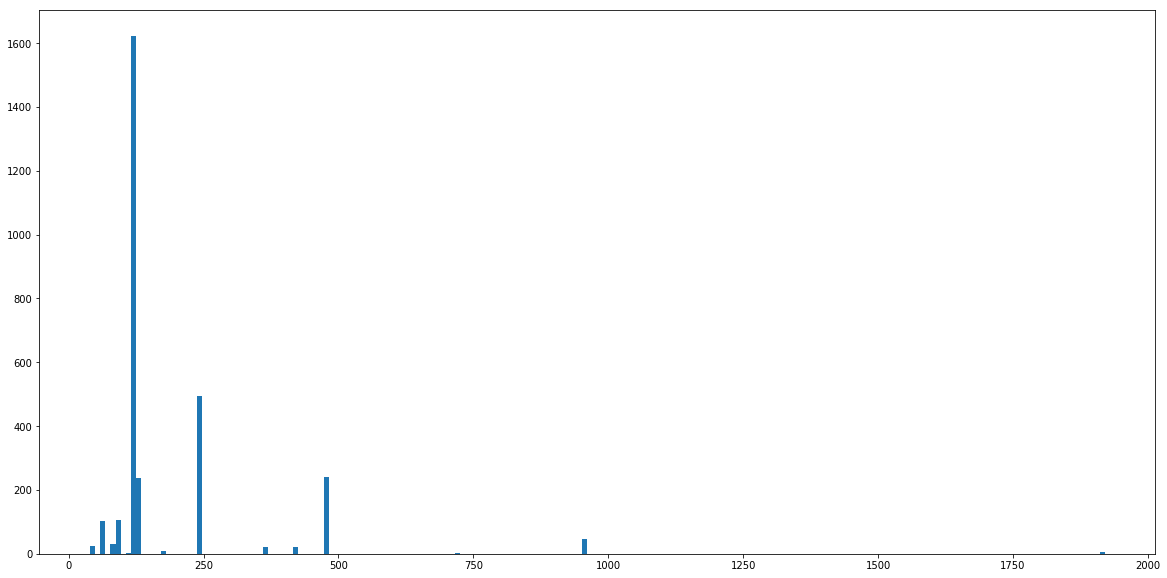

In [11]:
# Nekvantuota
plt.hist(df['length'], bins=200)
plt.show()

In [12]:
df['on'] = df['on'].apply(lambda x: quantize(x))
df['off'] = df['off'].apply(lambda x: quantize(x))

In [13]:
def findLength(on, off):
    return off - on

In [14]:
df['length'] = df.apply(lambda x: findLength(x['on'], x['off']), axis=1)

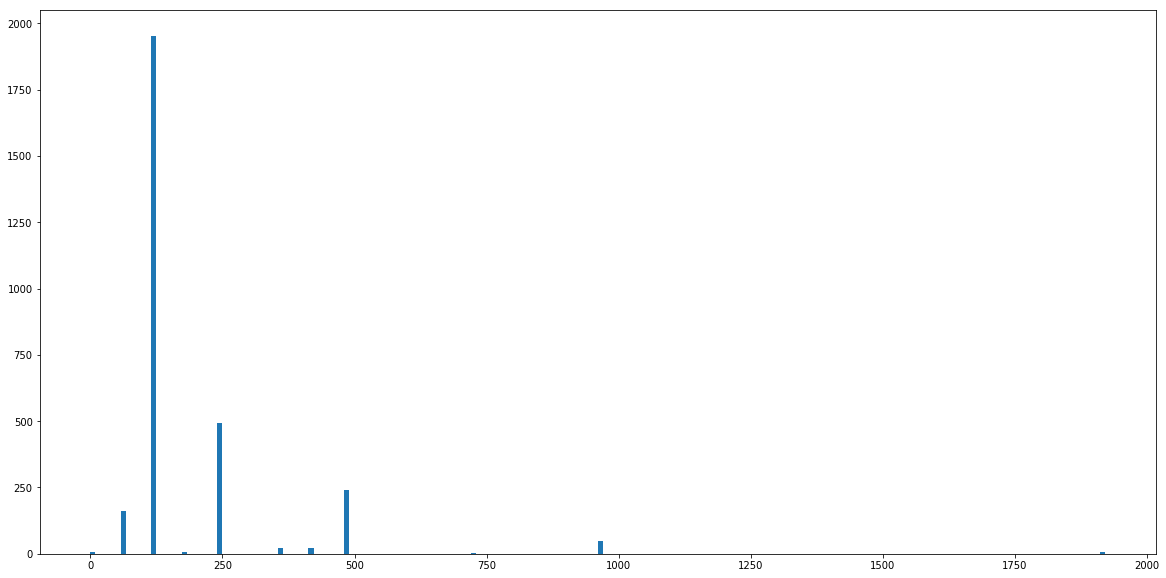

In [15]:
plt.hist(df['length'], bins=200)
plt.show()

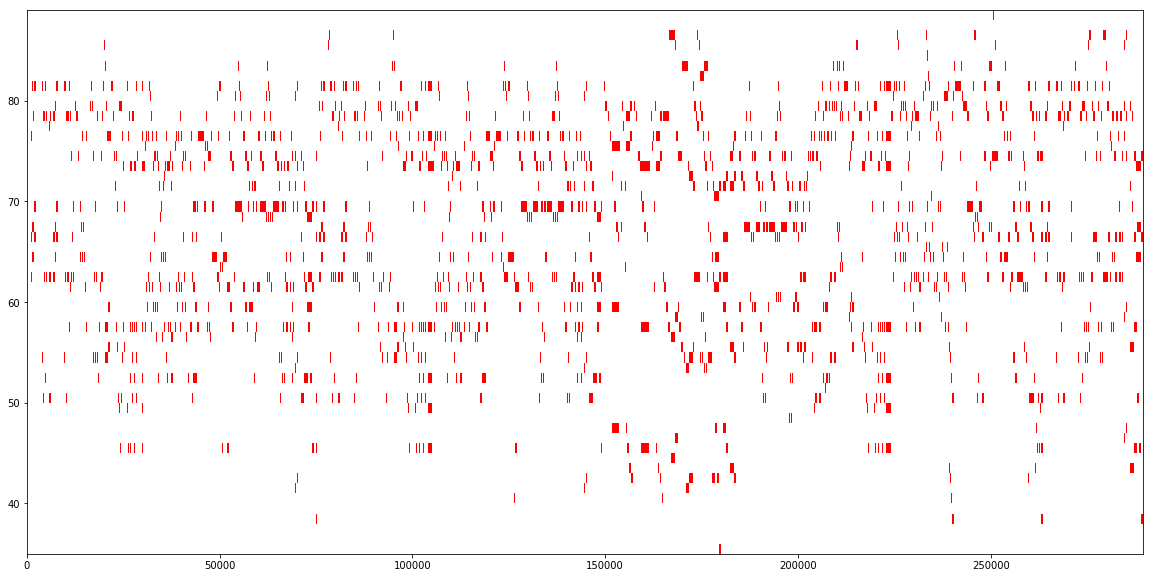

In [16]:
pianoRoll(df)

In [17]:
len(df)

2964

In [18]:
int(COUNTER['<>60']/2)

226

In [19]:
int(COUNTER['==60']/2)

2738

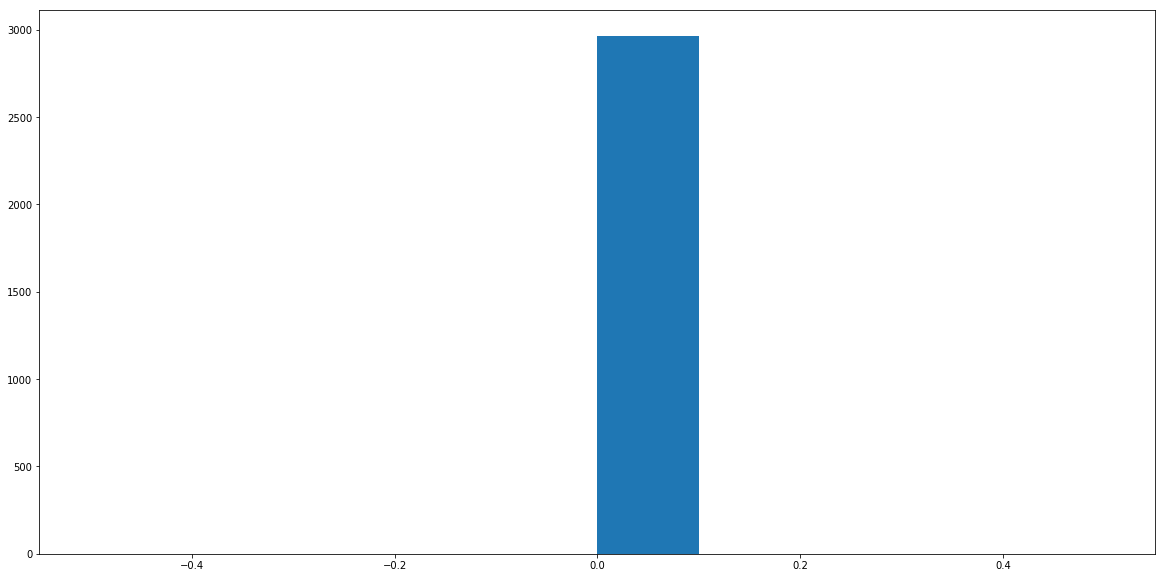

In [20]:
plt.hist(df['on'] % 60)
plt.show()

In [21]:
def toStateMatrix():
    length = df['off'].values[-1]
    steps = int(length / 60)
    stateMatrix = np.zeros((steps, 128), dtype=int)
    for row in df.itertuples():
        pitch = row[1]
        on = row[2]
        off = row[3]
        stateMatrix[int((on/60)) : int((off/60+1)), pitch] = 1
    return stateMatrix

In [186]:
stateMatrix = toStateMatrix()

In [187]:
def stateToMessage(stateMatrix):
    data = []
    notes = np.zeros(128, dtype=int)
    song = mido.MidiFile()
    track = mido.MidiTrack()
    song.tracks.append(track)
    for index, state in enumerate(stateMatrix):
        for i in range(128):
            if state[i] == 1:
                if notes[i] != 1:
                    notes[i] = 1
                    time = index * 60
                    data.append((147, i, 80, time))
            if index != 0:
                if state[i] == 0:
                    if stateMatrix[index - 1, i] == 1:
                        notes[i] = 0
                        time = (index - 1) * 60
                        data.append((147, i, 0, time))
    sortedData = sorted(data, key=lambda x: x[-1])
    return sortedData

In [188]:
messages = stateToMessage(stateMatrix)

In [197]:
def toMidi(messages, filename='Midi.mid'):
    song = mido.MidiFile()
    track = mido.MidiTrack()
    song.tracks.append(track)
    time = 0
    for message in messages:
        message = np.array(message)
        now = message[-1]
        delta = now - time
        time = now
        message[-1] = delta
        msg = mido.Message.from_bytes(message[:3])
        msg.time = delta
        track.append(msg)
    song.save(filename)

In [198]:
toMidi(messages)

In [27]:
data = stateMatrix
data.shape

(4824, 128)

In [28]:
trainLen = round(len(data) * 0.6)
testLen = len(data) - trainLen
initLen = 100

Text(0.5,1,'A sample of data')

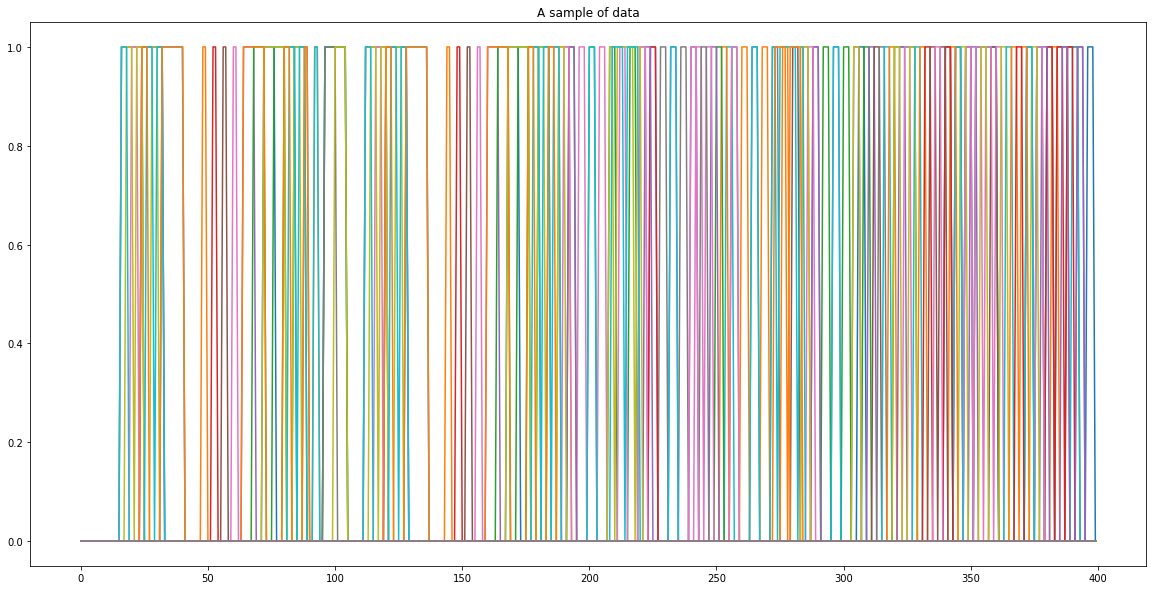

In [29]:
plt.figure(10).clear()
plt.plot(data[0:400])
plt.title('A sample of data')

Let us initialiaze the input and output sizes as well as the size of the reservoir. We shall add leaking rate as well.

In [30]:
inSize = outSize = 128
resSize = 1000
a = 0.8

In [31]:
np.random.seed(123)
Win = (np.random.rand(resSize, 1 + inSize) - 0.5) * 1
print('Win shape: {}'.format(Win.shape))
W = np.random.rand(resSize, resSize) - 0.5 
print('W shape: {}'.format(W.shape))
# Option 1 - direct scaling (quick&dirty, reservoir-specific):
# W *= 0.135 
# Option 2 - normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
rhoW = max(abs(lin.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

Win shape: (1000, 129)
W shape: (1000, 1000)
Computing spectral radius...
done.


In [32]:
# Allocated memory for the design (collected states) matrix
X = np.zeros((1 + inSize + resSize, trainLen - initLen))
print('X shape: {}'.format(X.shape))

# Set the corresponding target matrix directly
Yt = data[initLen + 1 : trainLen + 1]
print('Yt shape: {}'.format(Yt.shape))

X shape: (1129, 2794)
Yt shape: (2794, 128)


In [33]:
# Run the reservoir with the data and collect X
x = np.zeros((resSize, 1))

for t in range(trainLen):
#     u = data[t][:][np.newaxis].T
    u = data[t][:].reshape(-1, 1)
    x = (1 - a) * x + a * np.tanh( np.dot( Win, np.vstack((1, u)) ) + np.dot( W, x ) )
    if t >= initLen:
        X[:, t - initLen] = np.vstack((1, u, x))[:, 0]

In [34]:
Yt.shape

(2794, 128)

In [35]:
X.shape

(1129, 2794)

In [38]:
# train the output
reg = 1e+1  # regularization coefficient
X_T = X.T
Wout = np.dot( np.dot(Yt.T, X_T), lin.inv( np.dot(X, X_T) + reg * np.eye(1 + inSize + resSize)))
# Wout = dot( Yt, linalg.pinv(X) )

In [208]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize, testLen))

u = data[trainLen].reshape(-1, 1)
for t in range(testLen):
    x = (1 - a) * x + a * np.tanh( np.dot( Win, np.vstack((1, u)) ) + np.dot(W, x) )
    y = np.dot( Wout, np.vstack((1, u, x)) )
    Y[:,t] = y.T
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 

In [40]:
# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen + 1 : trainLen + errorLen + 1] - Y[0, 0 : errorLen].reshape(-1, 1) ) ) / errorLen
print('MSE = ' + str( mse ))

MSE = [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.018  0.     0.     0.     0.     0.     0.     0.07
  0.034  0.     0.018  0.     0.052  0.024  0.     0.024  0.     0.03
  0.012  0.106  0.184  0.012  0.12   0.012  0.154  0.072  0.064  0.22   0.
  0.05   0.     0.144  0.374  0.     0.114  0.04   0.252  0.144  0.04
  0.182  0.01   0.112  0.018  0.06   0.022  0.     0.02   0.034  0.042  0.
  0.018  0.01   0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]


In [41]:
data[trainLen + 1 : trainLen + testLen + 1][:,60][100]

0

In [42]:
Y.T[:,50]

array([ 0.06165249,  0.15339904,  0.05501325, ...,  0.04493167,
        0.13835964,  0.19084475])

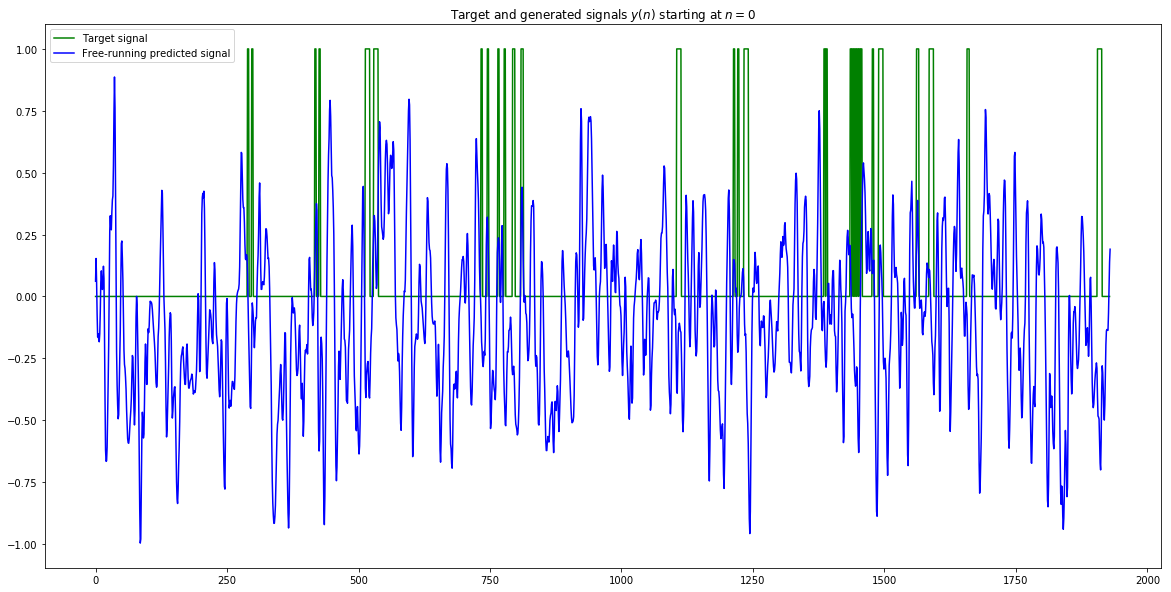

In [43]:
# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen + 1 : trainLen + testLen + 1][:,50], 'g' )
plt.plot( Y.T[:,50], 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

In [44]:
print(str(Y[50]))

[ 0.06165249  0.15339904  0.05501325 ...,  0.04493167  0.13835964
  0.19084475]


In [45]:
X.shape

(1129, 2794)

Text(0.5,1,'Some reservoir activations $\\mathbf{x}(n)$')

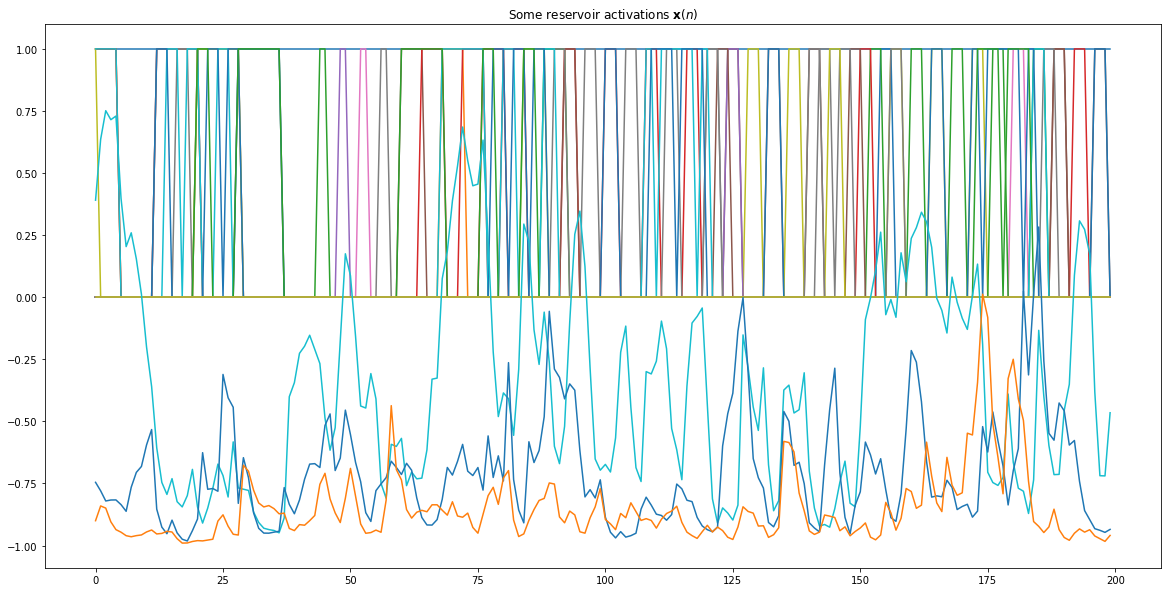

In [46]:
plt.figure(2).clear()
plt.plot( X[0:132,0:200].T)
plt.title('Some reservoir activations $\mathbf{x}(n)$')

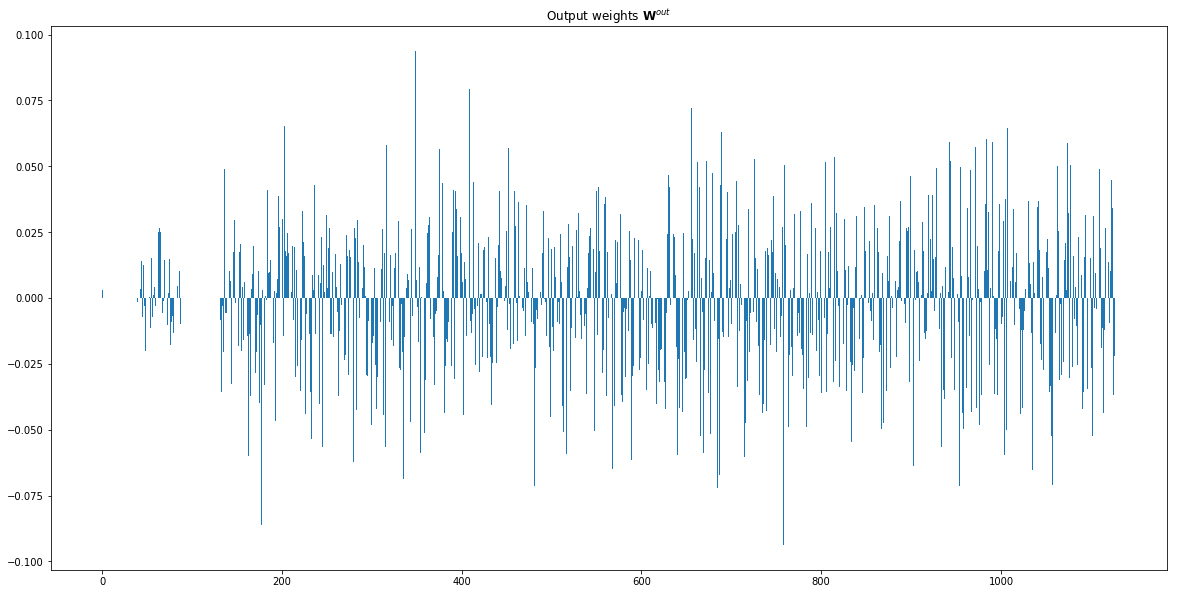

In [47]:
plt.figure(3).clear()
plt.bar( range(1+inSize+resSize), Wout.T[:, 54] )
plt.title('Output weights $\mathbf{W}^{out}$')
plt.show()

# Gautų natų svorių sutvarkymas

In [209]:
TEST = Y.T

In [210]:
for index1, value1 in enumerate(TEST):
    for index2, value2 in enumerate(value1):
        if (value2 > 0) and (random.random() < value2**2):
            TEST[index1, index2] = 1
        else:
            TEST[index1, index2] = 0

In [211]:
TEST

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

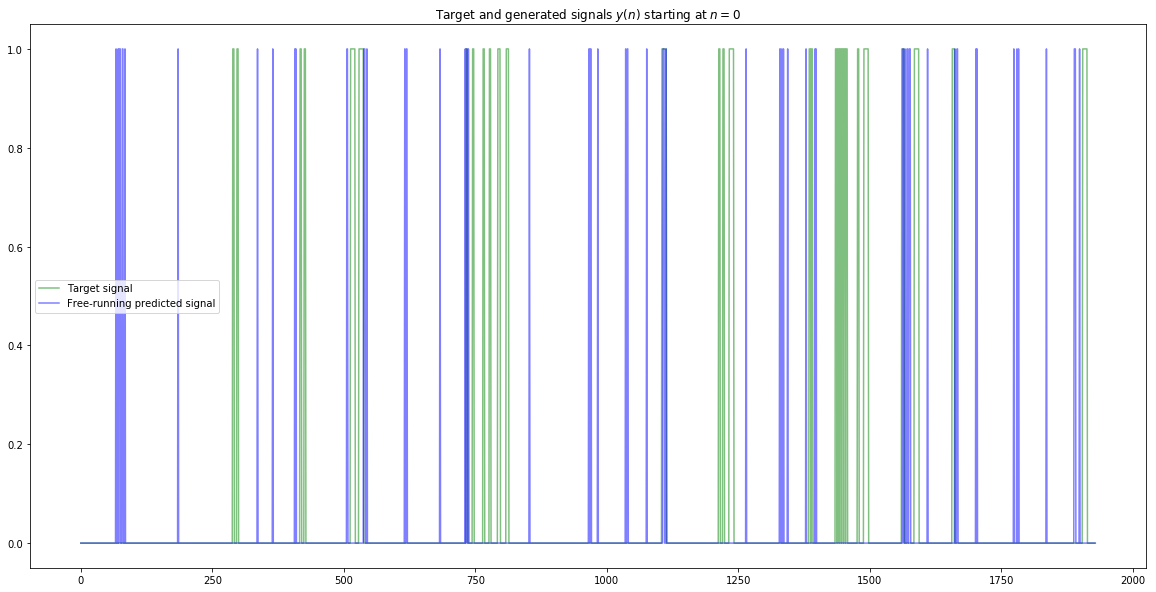

In [212]:
# plot some signals
plt.figure(3).clear()
plt.plot( data[trainLen + 1 : trainLen + testLen + 1][:,50], 'g', alpha=0.5)
plt.plot( TEST[:,50], 'b', alpha=0.5)
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

In [213]:
TEST.shape

(1930, 128)

In [214]:
newMidiMessages = stateToMessage(TEST)

In [215]:
toMidi(newMidiMessages, 'NewMidi.mid')